#### VPC flow logs loader
This notebook ingests VPC flow logs from a folder into a dataframe and plots them by flow and byte count so you can see at a glance if the data range and shape is as expected. If the byte count spikes above the moving average and Bollinger Bands. as in the example output below,  that can be one way of spotting exfil. After loading, you can export to csv for ingestion into ML or hunting notebooks, or run additional anlytics here.

In [ ]:
import ipaddress
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import pandas as pd

In [ ]:
# Place the folder name in root_dir to ingest VPC flow logs (assuming native format)

root_dir = r"2024"

dataframes = []

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        
        if file.endswith(".log"):
            file_path = os.path.join(subdir, file)
            
            df = pd.read_csv(file_path, delimiter=' ')  
            dataframes.append(df)

vflows = pd.concat(dataframes, ignore_index=True)

In [ ]:
# Cast fields and timestamps

vflows['bytes'] = pd.to_numeric(vflows['bytes'], errors='coerce')
vflows['packets'] = pd.to_numeric(vflows['packets'], errors='coerce')
vflows['start'] = pd.to_datetime(vflows['start'], unit='s')
vflows['end'] = pd.to_datetime(vflows['end'], unit='s')
columns = ["start", "end"] + [col for col in vflows.columns if col not in [ "start", "end"]]
vflows = vflows[columns]
#vflows.head()

In [55]:
# Optionally import from a previosuly generated csv 
# flows = pd.read_csv('flows.csv', low_memory = False)

In [121]:
# Prepare counts for plotting

vflows['bytes'] = pd.to_numeric(vflows['bytes'], errors='coerce')
vflows['packets'] = pd.to_numeric(vflows['packets'], errors='coerce')
vflows = vflows.dropna(subset=['bytes', 'packets'])


dates = pd.to_datetime(vflows['start']).to_numpy()  
bytes_arr = vflows['bytes'].to_numpy()
packets_arr = vflows['packets'].to_numpy()

months = np.array([pd.Timestamp(d).strftime('%Y-%m') for d in dates])  
dates_exact = np.array([pd.Timestamp(d).strftime('%Y-%m-%d') for d in dates])  
unique_dates, inverse_indices = np.unique(dates.astype('datetime64[D]'), return_inverse=True)

flows_count = np.bincount(inverse_indices)  
bytes_sum = np.bincount(inverse_indices, weights=bytes_arr)  
packets_sum = np.bincount(inverse_indices, weights=packets_arr)  

unique_months = np.array([pd.Timestamp(d).strftime('%Y-%m') for d in unique_dates])
unique_dates_exact = np.array([pd.Timestamp(d).strftime('%Y-%m-%d') for d in unique_dates])

result = np.rec.fromarrays(
    [unique_dates_exact, unique_months, flows_count, bytes_sum, packets_sum],
    names=('date', 'month', 'Flows', 'Bytes', 'Packets')
)

data = pd.DataFrame(result)
print(data)



           date    month   Flows         Bytes     Packets
0    2020-03-06  2020-03    3089  8.723171e+07     97171.0
1    2020-03-07  2020-03   18462  1.222658e+08    270105.0
2    2020-03-08  2020-03   19957  3.363648e+08    474430.0
3    2020-03-09  2020-03   27999  1.891986e+08    364747.0
4    2020-03-10  2020-03   36470  2.129501e+08    370671.0
..          ...      ...     ...           ...         ...
471  2024-07-24  2024-07  131876  1.443873e+09   2613771.0
472  2024-07-25  2024-07  134655  7.606558e+10  60360770.0
473  2024-07-26  2024-07  124322  5.330987e+08   1366949.0
474  2024-07-27  2024-07  110397  4.634399e+08   1264644.0
475  2024-07-28  2024-07   80378  3.464647e+08    974066.0

[476 rows x 5 columns]


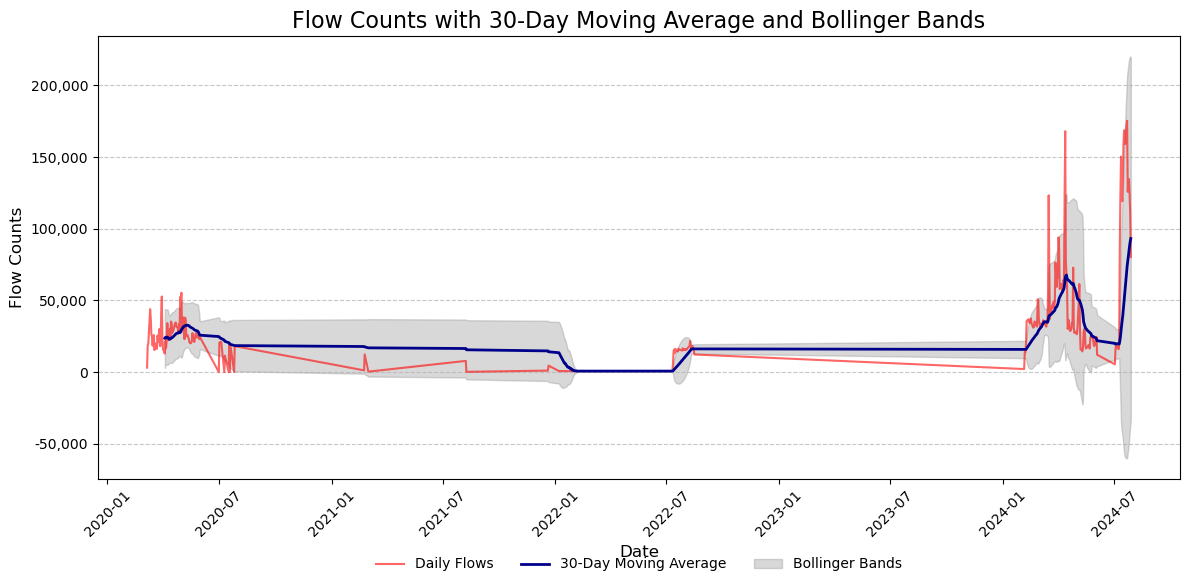

In [125]:
# Plot flow count 30 day moving average with BBs

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')
data['Flows_30D_MA'] = data['Flows'].rolling(window=30).mean()
data['Flows_30D_STD'] = data['Flows'].rolling(window=30).std()
data['Upper_Band'] = data['Flows_30D_MA'] + (2 * data['Flows_30D_STD'])
data['Lower_Band'] = data['Flows_30D_MA'] - (2 * data['Flows_30D_STD'])

def comma_formatter(x, _):
    return f'{x:,.0f}'

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['Flows'], label='Daily Flows', color='red', alpha=0.6)
plt.plot(data['date'], data['Flows_30D_MA'], label='30-Day Moving Average', color='darkblue', linewidth=2)
plt.fill_between(data['date'], data['Upper_Band'], data['Lower_Band'], color='grey', alpha=0.3, label='Bollinger Bands')
plt.title('Flow Counts with 30-Day Moving Average and Bollinger Bands', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Flow Counts', fontsize=12)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_formatter))
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

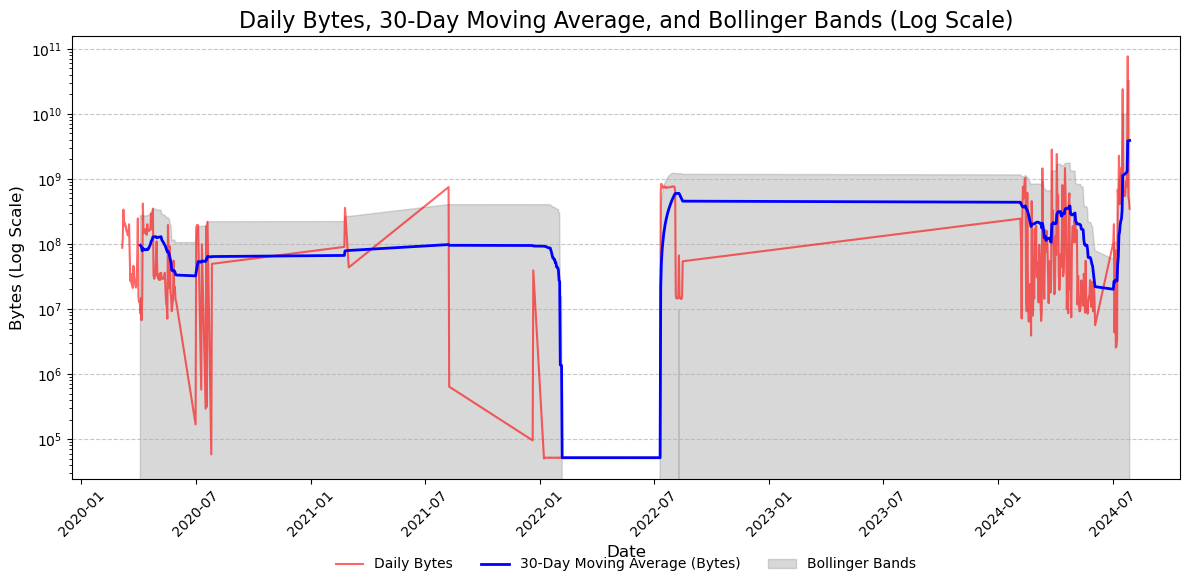

In [127]:
# Plot byte count 30 day moving average with BBs

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')
data['Bytes_30D_MA'] = data['Bytes'].rolling(window=30).mean()
data['Bytes_30D_STD'] = data['Bytes'].rolling(window=30).std()
data['Bytes_Upper_Band'] = data['Bytes_30D_MA'] + (2 * data['Bytes_30D_STD'])
data['Bytes_Lower_Band'] = data['Bytes_30D_MA'] - (2 * data['Bytes_30D_STD'])

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['Bytes'], label='Daily Bytes', color='red', alpha=0.6)
plt.plot(data['date'], data['Bytes_30D_MA'], label='30-Day Moving Average (Bytes)', color='blue', linewidth=2)
plt.fill_between(data['date'], data['Bytes_Upper_Band'], data['Bytes_Lower_Band'], 
                 color='grey', alpha=0.3, label='Bollinger Bands')
plt.yscale('log')
plt.title('Daily Bytes, 30-Day Moving Average, and Bollinger Bands (Log Scale)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bytes (Log Scale)', fontsize=12)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()